In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sys

from matplotlib import pyplot as plt
from matplotlib import cm

from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

In [2]:
sys.path.append("..")
from views_utils.dbutils import make_connectstring, query_to_df

In [3]:
q_months = """
SELECT id, month, year_id
FROM staging.month;
"""
connectstring = make_connectstring(db="views", hostname="VIEWSHOST", port="5432", prefix="postgres",uname="VIEWSADMIN")
df_months = query_to_df(query=q_months, connectstring=connectstring)
df_months.set_index(['id'], inplace=True)

In [4]:
def month_id_to_datestr(df_months, month_id):
    datestr = str(df_months.loc[month_id]['year_id']) + "-" + str(df_months.loc[month_id]['month'])
    return datestr

In [5]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Credit: #https://gist.github.com/phobson/7916777

    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
def prune_africa(df, rmin, rmax, cmin, cmax):
    #The sea-cells closesest to each tip of mainland Africa

    df = df[df['row']>= rmin]
    df = df[df['row']<= rmax]
    df = df[df['col']>= cmin]
    df = df[df['col']<= cmax]
    return df

In [6]:
#fcast_canon_full_calib/
#fcast_canon_full_test/


In [6]:
dir_run = "/Users/VIEWSADMIN/ds/uppmax/sync/fcast_canon_full_test/"
path_probs = dir_run + "output/aggregated.csv"
path_geo = "/Users/VIEWSADMIN/ds/plots/geo.hdf5"
path_input = "/Users/VIEWSADMIN/ds/input_update/pgm/data/imp_imp_1.hdf5"
path_cshapes = "/Users/VIEWSADMIN/github/Views/spatial/cshapes_0.6/cshapes"
path_pg_shapes = "/Users/VIEWSADMIN/github/Views/spatial/priogrid/priogrid2"
dir_output = "/Users/VIEWSADMIN/maps/updated/fcast_canon_full_test/"

months = range(455, 455+36)

zoom_africa     = {'name' : 'africa',   'coords' : (110, 256, 324,464)}
zoom_nig        = {'name' : 'nigeria',  'coords' : (110+80, 256-45, 324+40,464-60)}
zoom_darfur     = {'name' : 'darfur',   'coords' : (110+75, 256-35, 324+75,464-20)}
zoom_sl         = {'name' : 'sl',       'coords' : (110+84, 256-56, 324+10,464-125)}
zoom_somalia    = {'name' : 'somalia',  'coords' : (110+50, 256-50, 324+100,464)}
zoom_drcongo    = {'name' : 'drcongo',  'coords' : (110+35, 256-65, 324+50,464-30)}
zoom_wide       = {'name' : 'wide',     'coords' : (110+44, 256-39, 324, 464 )}

zoomz = [zoom_africa, zoom_nig, zoom_darfur, zoom_sl, zoom_somalia, zoom_drcongo, zoom_wide]
#zoomz = [zoom_somalia, zoom_drcongo]

#zoomz = [zoom_wide]

outcomes = ['ged_dummy_sb', 'ged_dummy_ns','ged_dummy_os']

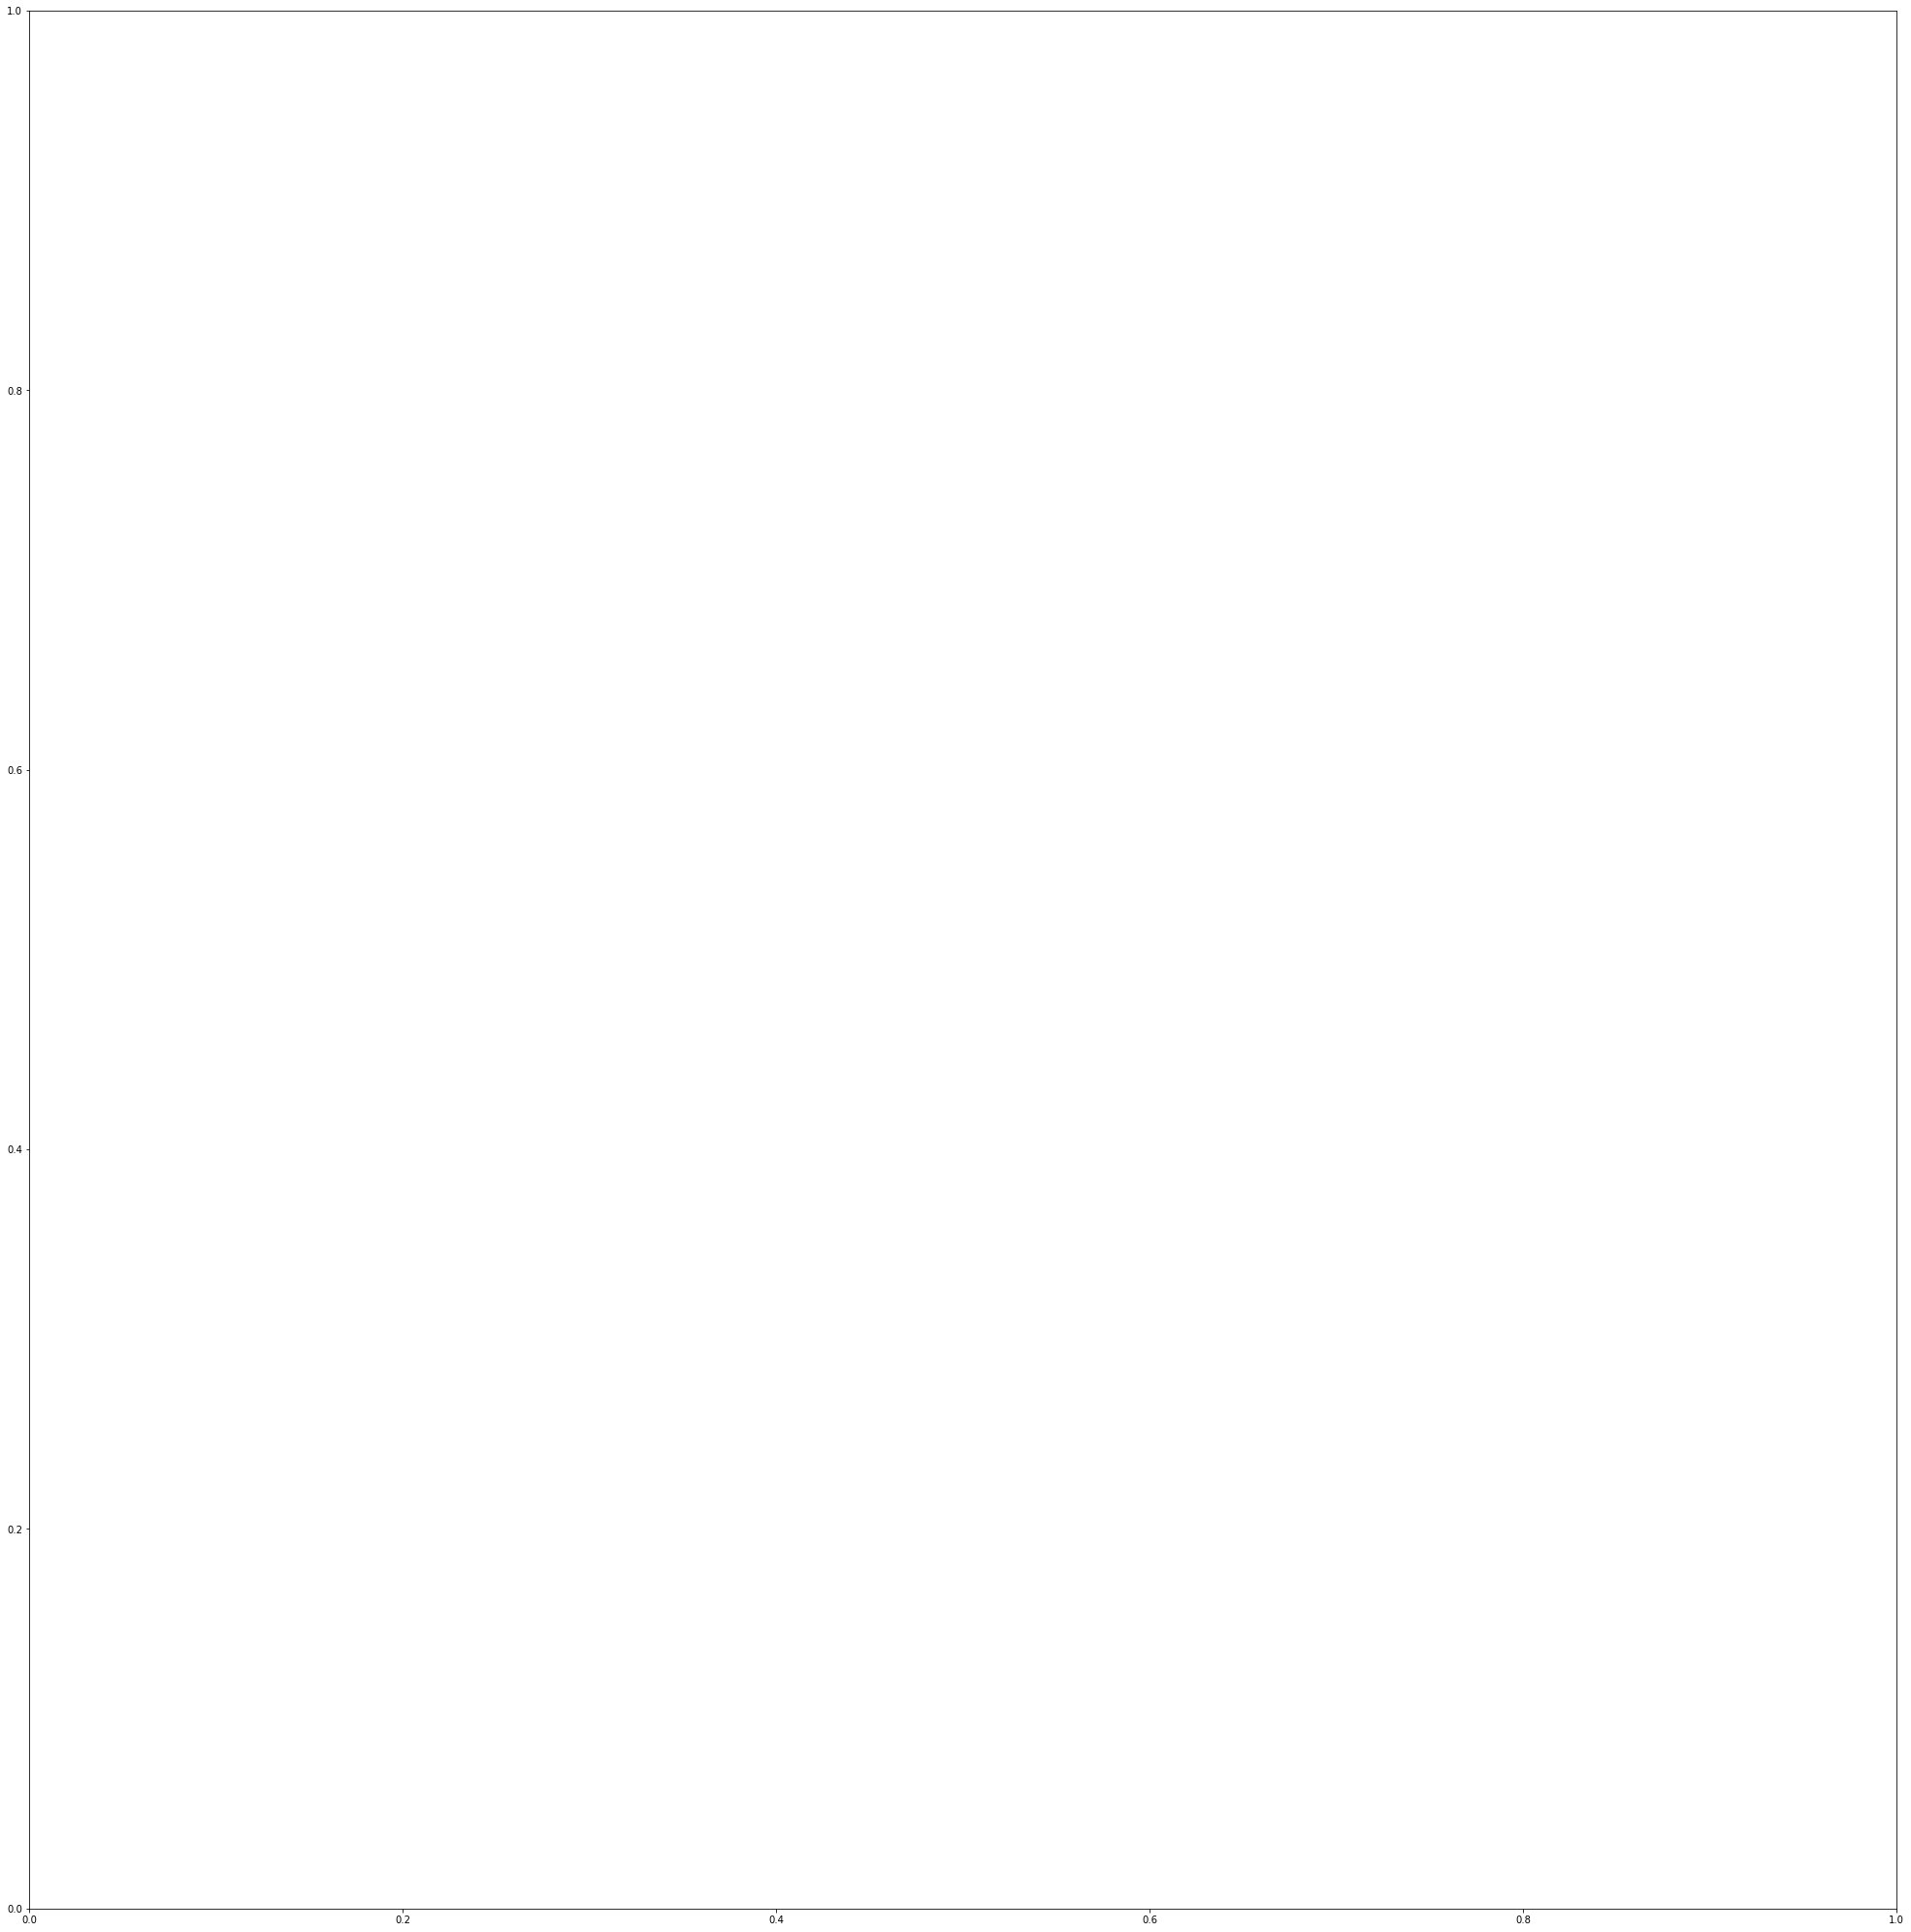

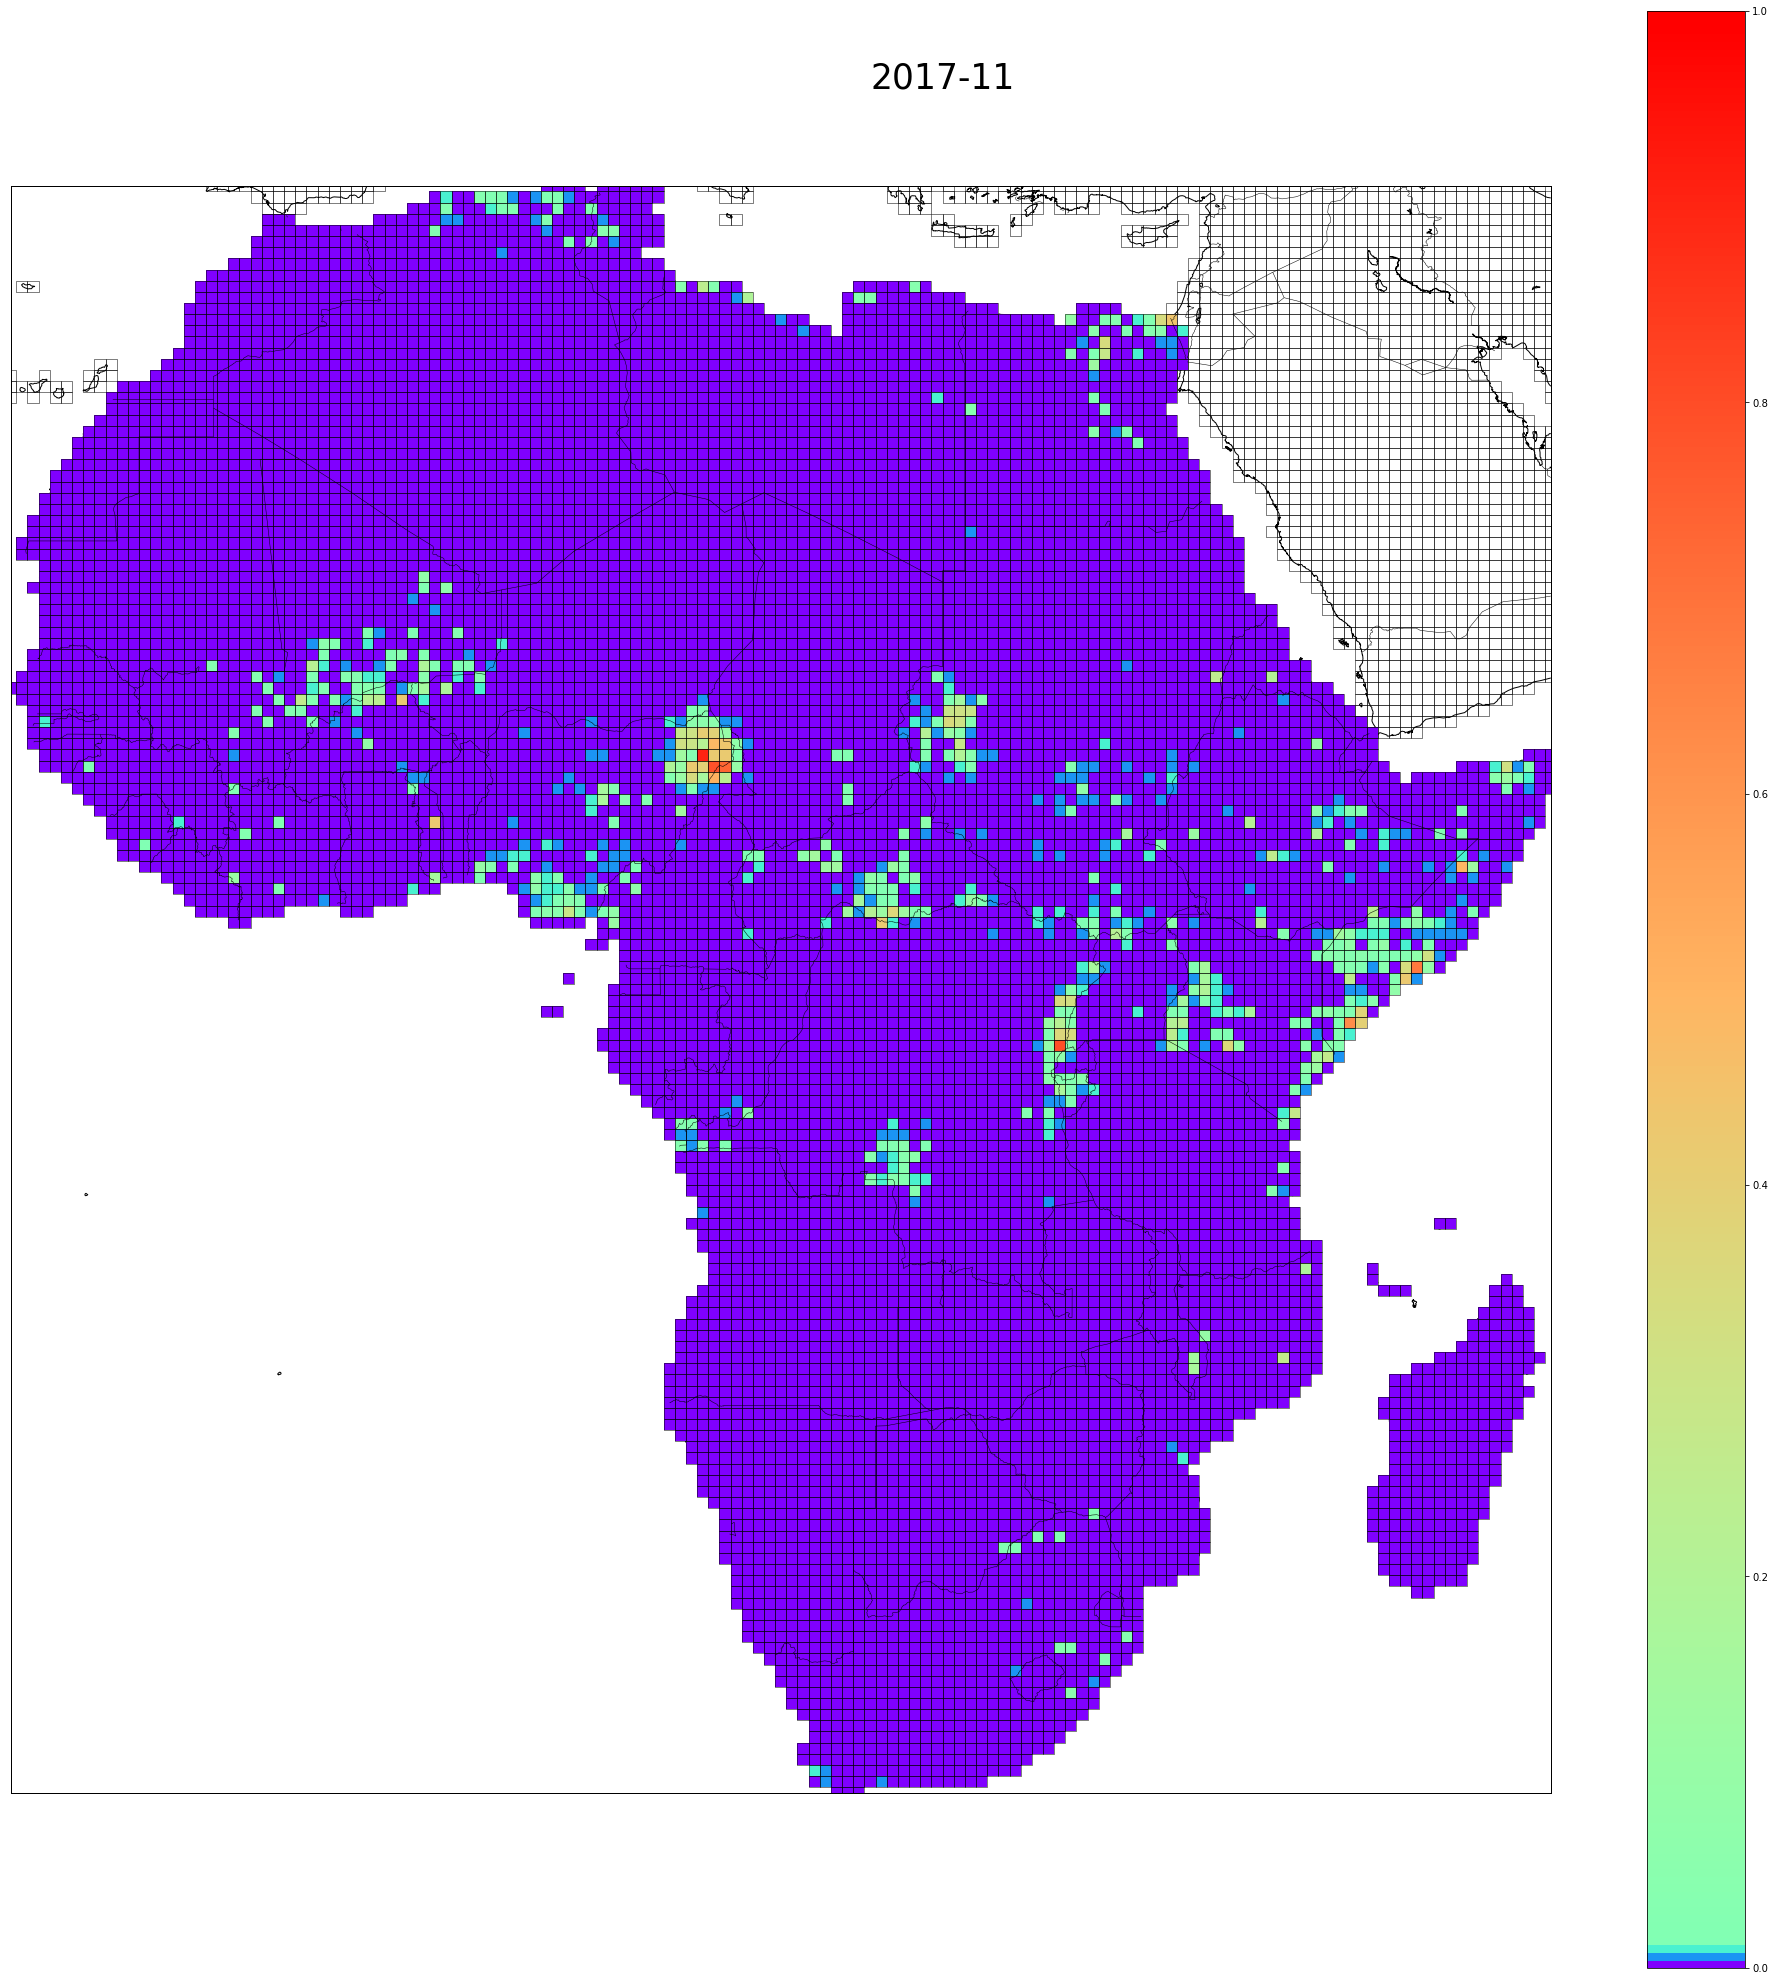

KeyboardInterrupt: 

In [9]:
for outcome in outcomes:

    df_geo = pd.read_hdf(path_geo)
    df_geo_base = prune_africa(df_geo, 110, 256, 324, 464)


    df_probs = pd.read_csv(path_probs)
    df_probs.set_index(['month_id', 'pg_id'], inplace=True)
    name_outcome_mean = outcome + "_mean"
    df_probs = df_probs[[name_outcome_mean]]

    df_events = pd.read_hdf(path_input)
    df_events.set_index(['month_id', 'pg_id'], inplace=True)
    df_events = df_events[[outcome]]
    df_events = df_events[df_events[outcome]==1]



    cmap = plt.get_cmap("rainbow")
    cmap = shiftedColorMap(cmap, 0, 0.01, 1)


    for zoom in zoomz:
        df_geo = prune_africa(df_geo_base, 
            zoom['coords'][0], zoom['coords'][1], zoom['coords'][2], zoom['coords'][3])


        lon_min = df_geo.longitude.min()
        lon_max = df_geo.longitude.max()
        lat_min = df_geo.latitude.min()
        lat_max = df_geo.latitude.max()
        width = lon_max - lon_min
        height = lat_max - lat_min
        scale = 0.5 # inches per degree
        size = (width*scale, height*scale)

        df_event_coords = df_geo.merge(df_events, left_index=True, right_index=True)
        df_event_coords = df_event_coords[['longitude', 'latitude']]

        for t in months:
            df_probs_t = df_probs.loc[t]
            df_event_coords_t = df_event_coords.loc[t]
            events = [tuple(x) for x in df_event_coords_t.values]

            fig = plt.figure(figsize = size)
            fig.canvas.set_window_title('month_id')
            ax = fig.add_subplot(111)
            map = Basemap(llcrnrlon=lon_min,
                        llcrnrlat=lat_min,
                        urcrnrlon=lon_max,
                        urcrnrlat=lat_max,
                        resolution='i', 
                        projection='cyl',
                        suppress_ticks=True)
            map.drawmapboundary(fill_color='white')
            #map.fillcontinents(color='gray',lake_color='aqua')
            map.drawcoastlines()
            for event in events:
                x,y = map(event[0], event[1])
                map.plot(x, y, marker='.', color='black', label='event', markersize=10)

            map.readshapefile(path_pg_shapes, 'pggid', drawbounds=False)
            patches = []
            colors = []
            for info, shape in zip(map.pggid_info, map.pggid):
                gid = info['pggid']
                if gid in df_probs_t.index.values:
                    prob = df_probs_t.loc[gid]
                    patch = Polygon(np.array(shape), True)
                    patches.append(patch)
                    colors.append(prob)

            collection = PatchCollection(patches, zorder=2)
            collection.set_array(np.array(colors).flatten())
            collection.set_cmap(cmap)
            collection.set_clim(0,1)
            ax.add_collection(collection)
            map.readshapefile(path_pg_shapes, 'pggid')
            #map.readshapefile(path_cshapes, 'gwcode')
            map.drawcountries()

            plt.colorbar(collection)
            #plt.title(month_id_to_datestr(df_months, t))
            plt.figtext(.5,.85,str(month_id_to_datestr(df_months, t)), fontsize=size[0], ha='center')


            plt.show()

            path = dir_output + outcome + "_" + zoom['name'] + "_" + str(t) + ".png"
            #plt.savefig(path)
            #print("wrote", path)
            #plt.close() 

In [ ]:
month_id_to_datestr(df_months, 454)